Looking at the Kepler light curve of Kepler 51, seeing if there is any evidence of an activity cycle. 

Kap 1 ceti cycle: https://ui.adsabs.harvard.edu/abs/2022A%26A...658A..16B/abstract

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec

import lightkurve as lk


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
search_result = lk.search_lightcurve('kplr011773022')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 01,2009,Kepler,1800,kplr011773022,0.0
1,Kepler Quarter 02,2009,Kepler,1800,kplr011773022,0.0
2,Kepler Quarter 03,2009,Kepler,1800,kplr011773022,0.0
3,Kepler Quarter 04,2010,Kepler,1800,kplr011773022,0.0
4,Kepler Quarter 05,2010,Kepler,1800,kplr011773022,0.0
5,Kepler Quarter 06,2010,Kepler,1800,kplr011773022,0.0
...,...,...,...,...,...,...
27,Kepler Quarter 16,2013,Kepler,60,kplr011773022,0.0
28,Kepler Quarter 16,2013,Kepler,60,kplr011773022,0.0


8.185147131799164 d
4.089216548525649 d
4.163298440553741 d
8.25129105964385 d
8.385418976304594 d
8.176801794757237 d
8.089120541893303 d
8.390991082093269 d
8.242316988534691 d
8.503869533468295 d


/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/lightkurve/lightcurve.py:1956: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1)


8.449533869666244 d
8.191482527281295 d
8.265413446318982 d
8.236299894796053 d
8.537166345199243 d
8.291078591176 d
9.214339120219769 d


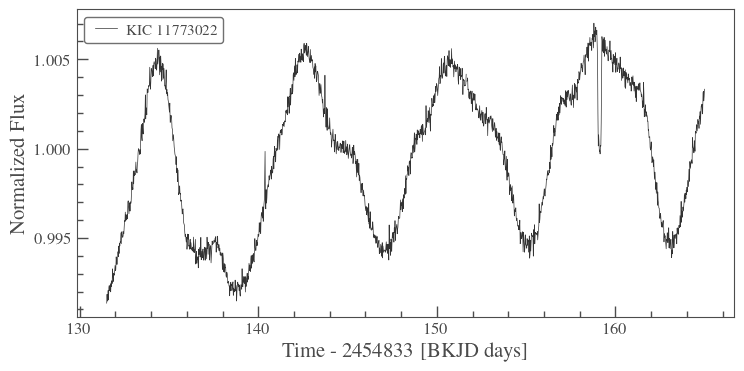

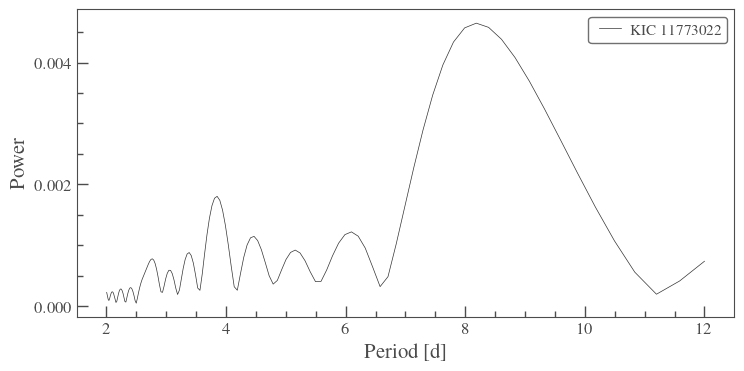

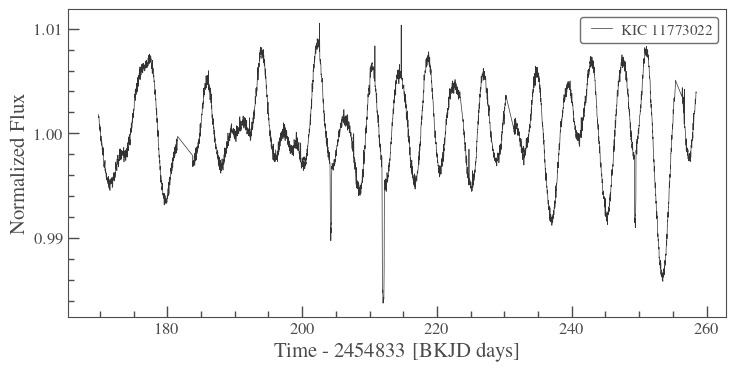

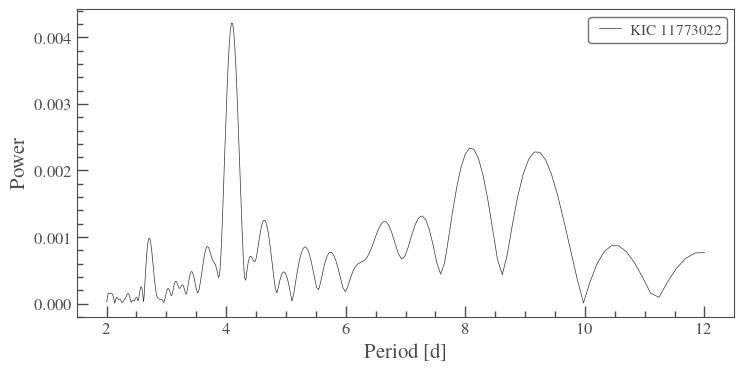

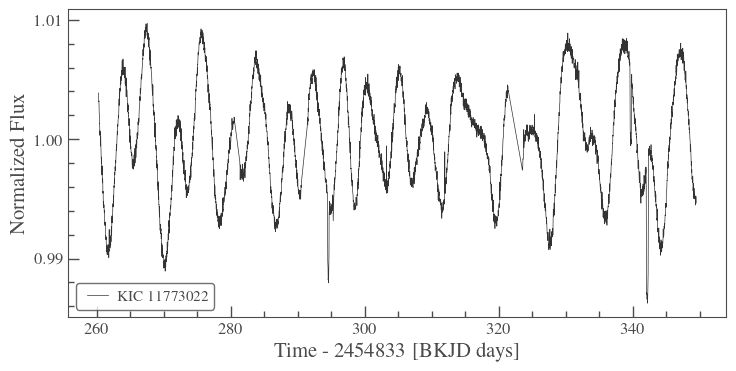

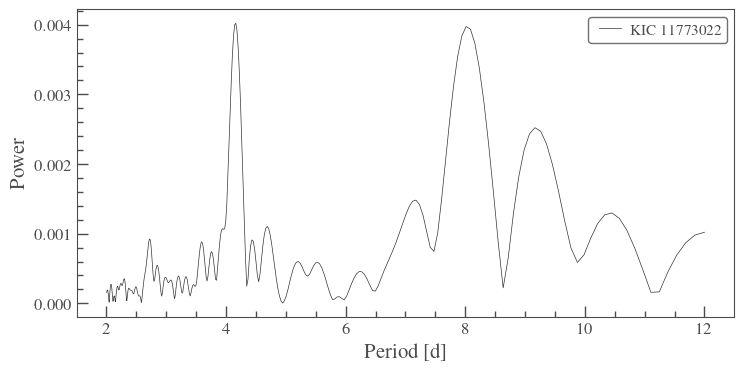

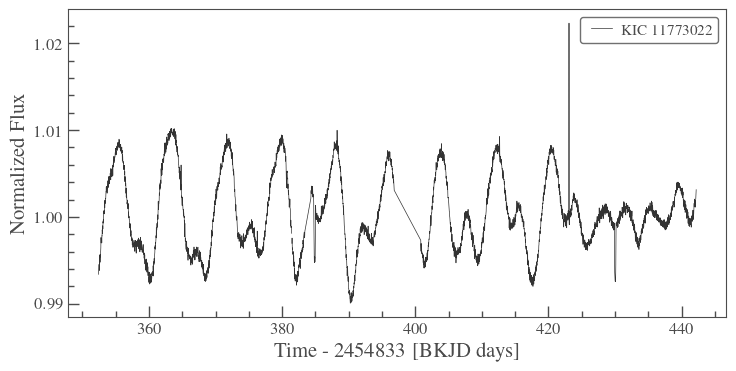

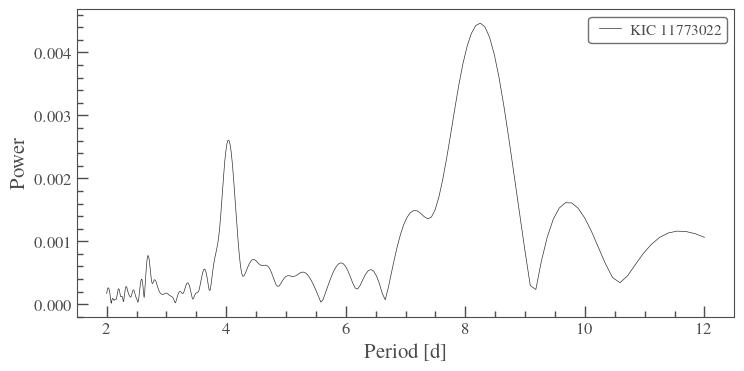

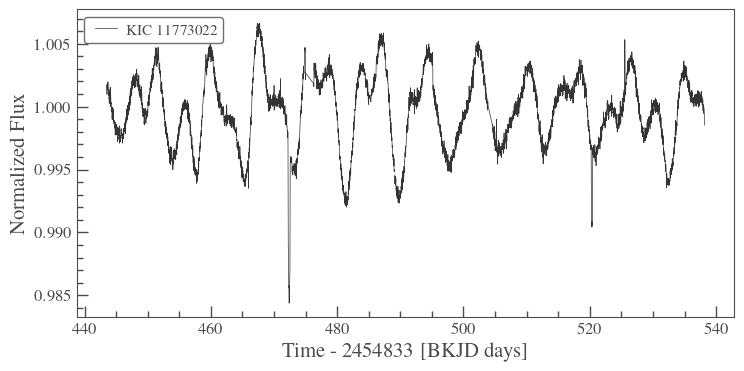

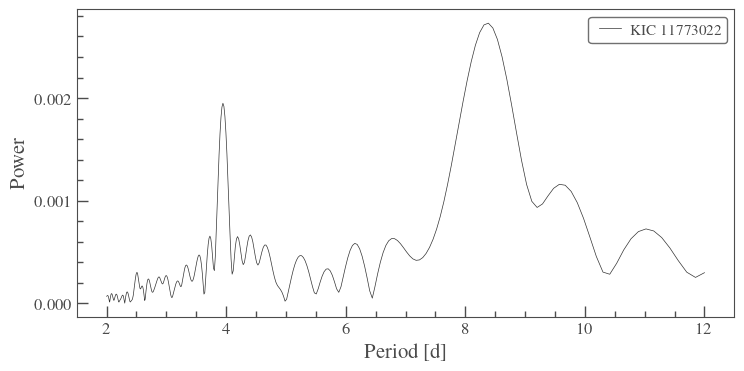

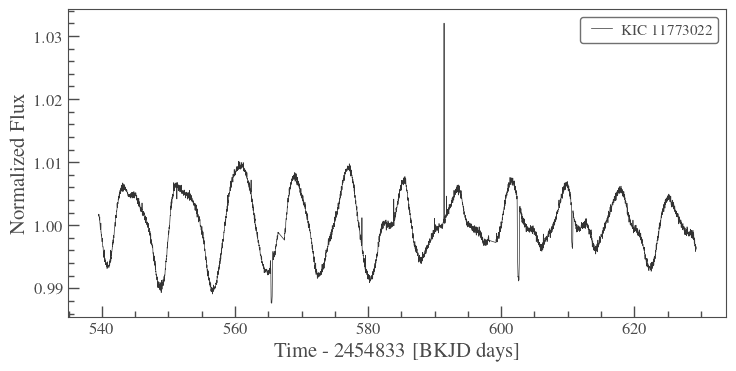

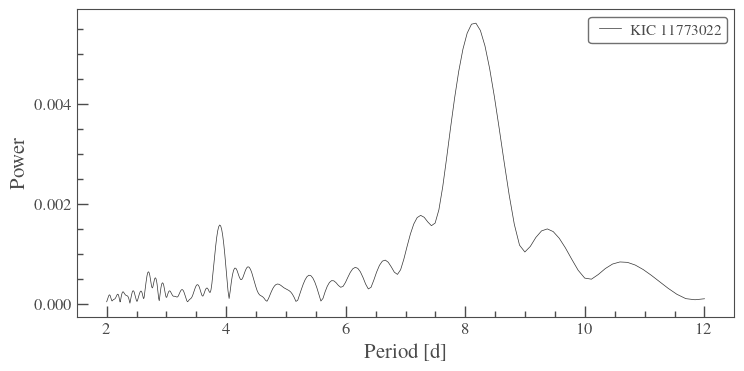

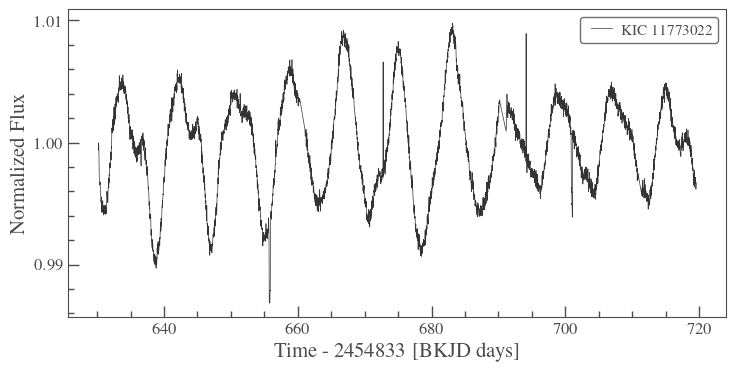

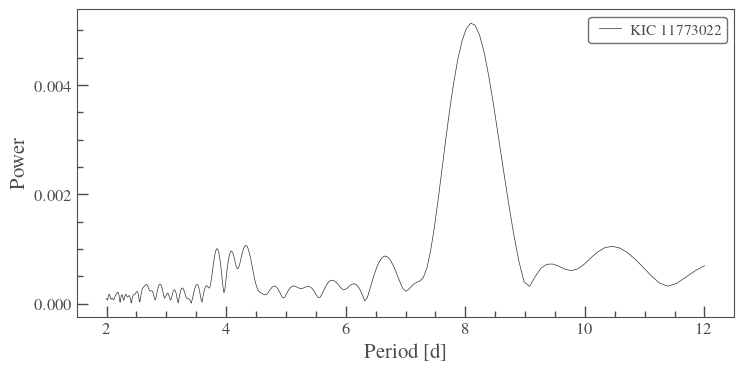

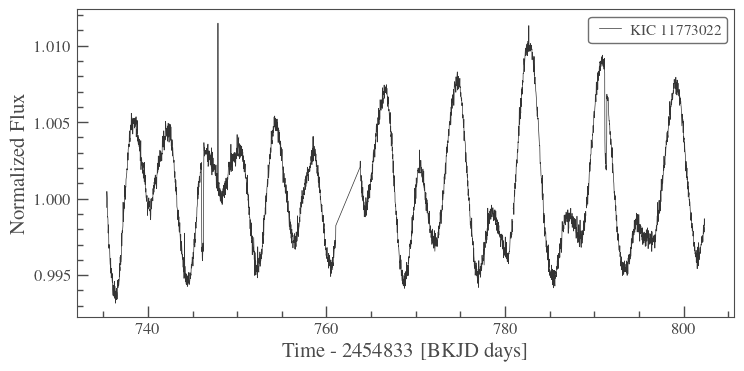

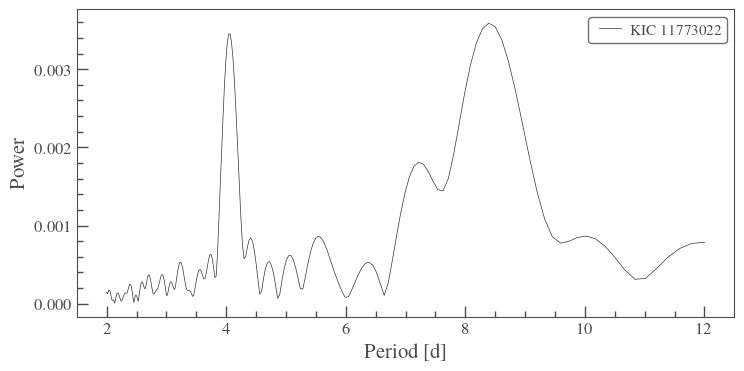

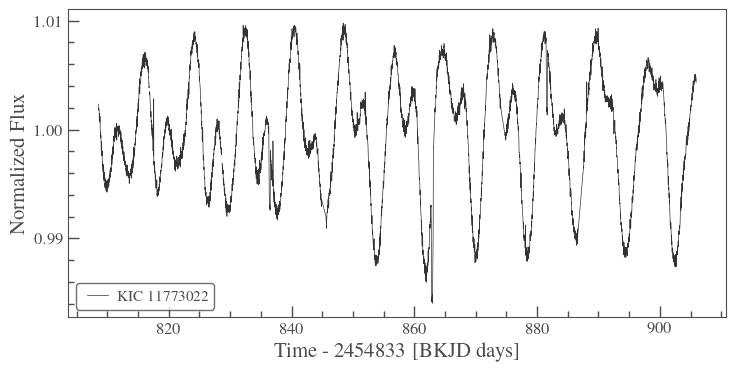

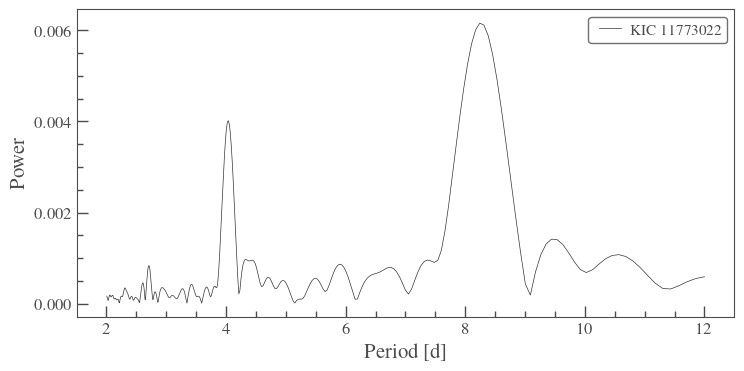

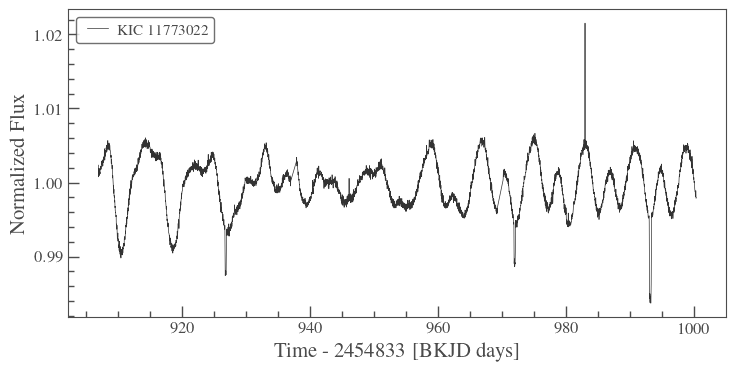

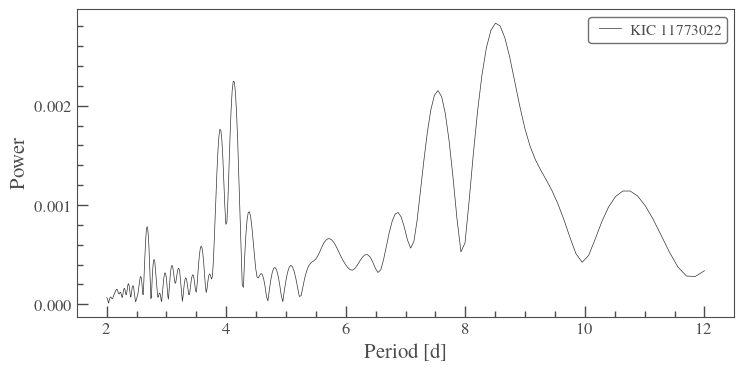

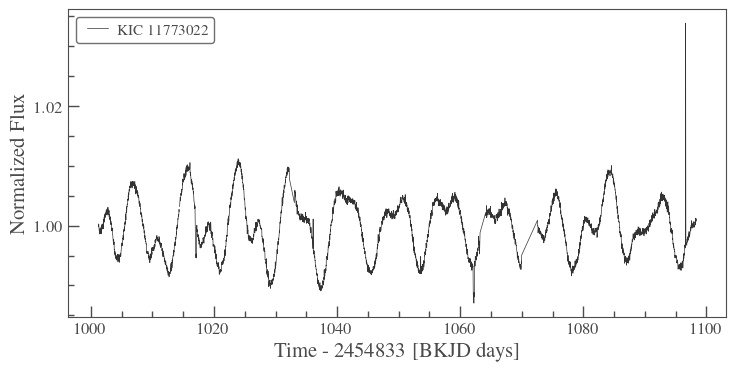

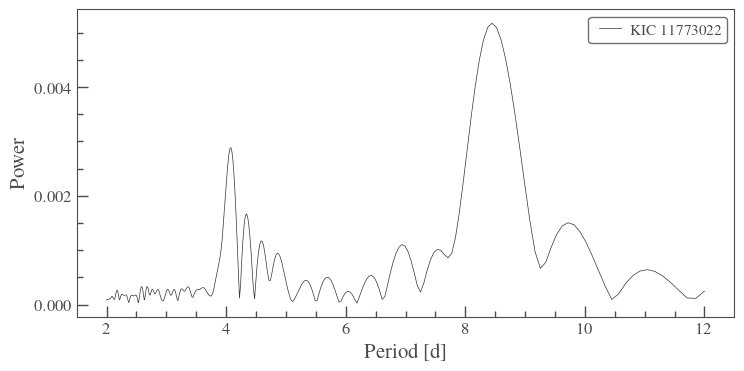

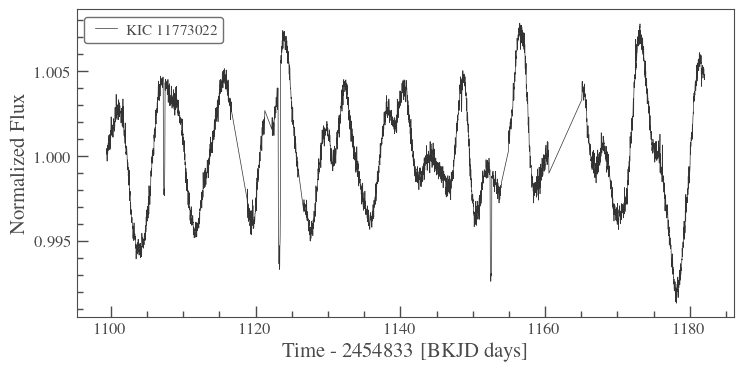

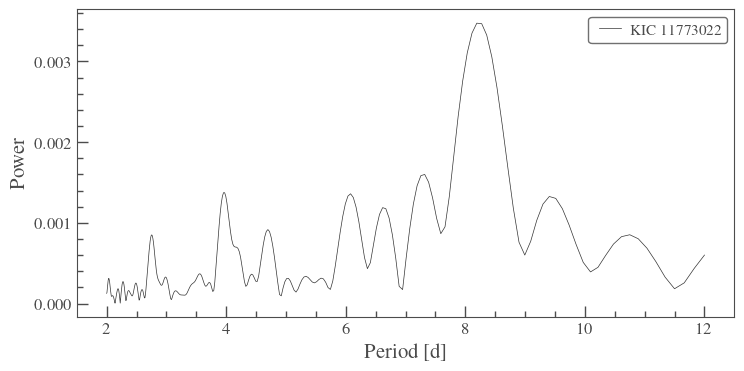

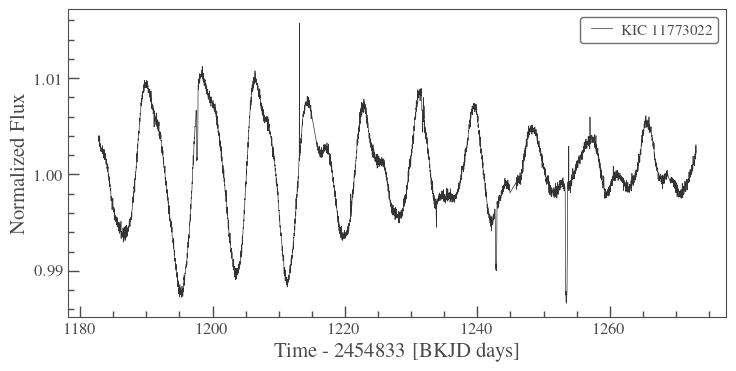

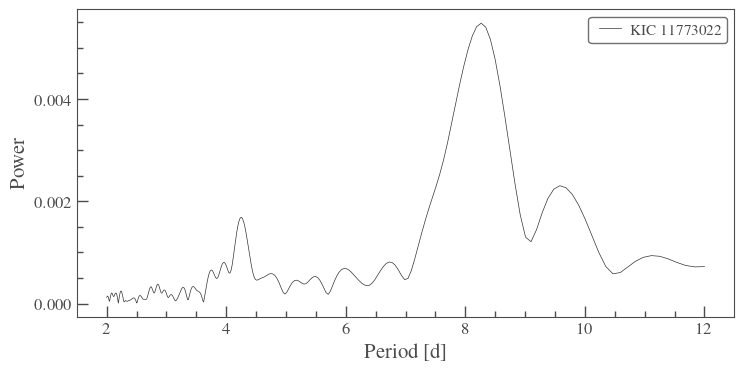

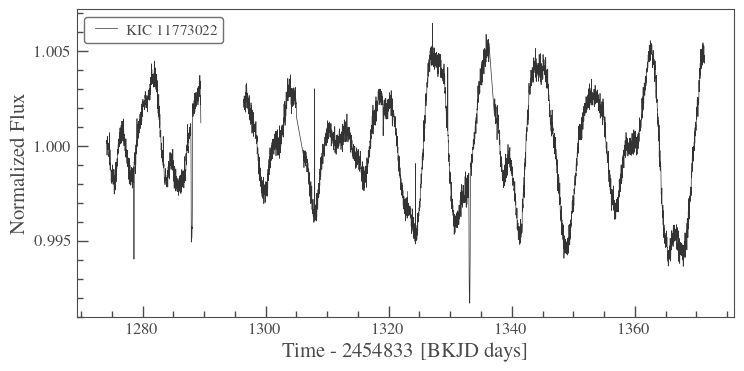

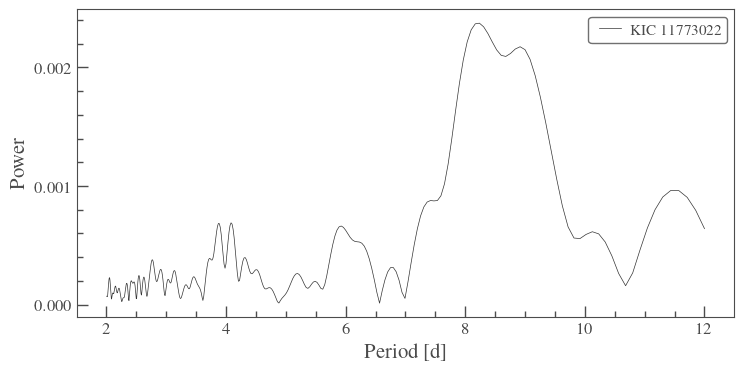

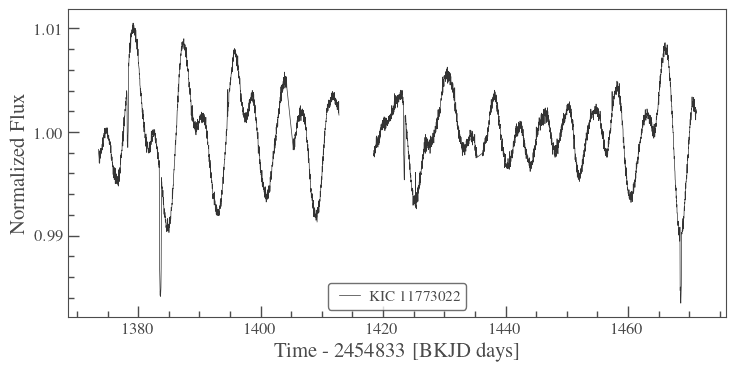

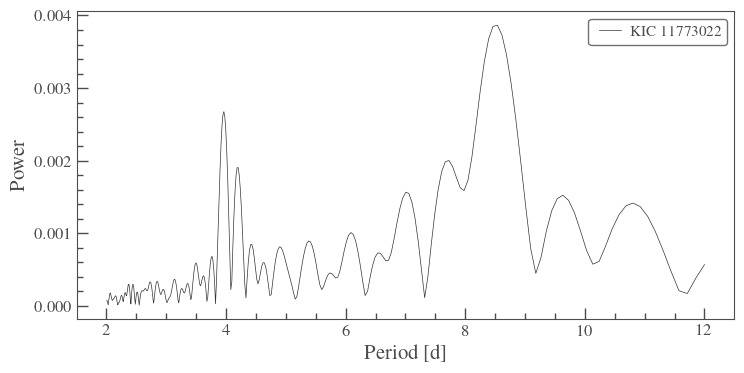

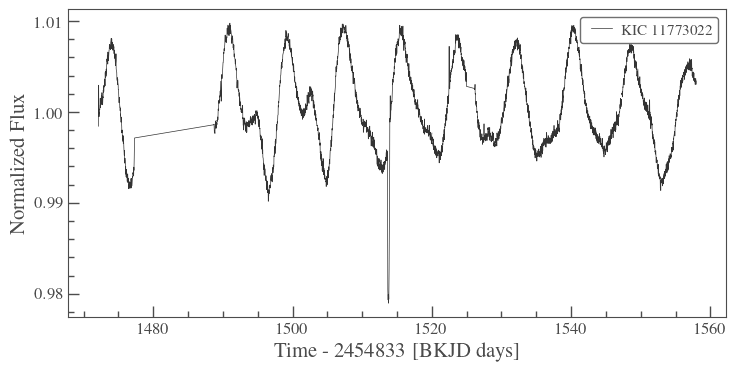

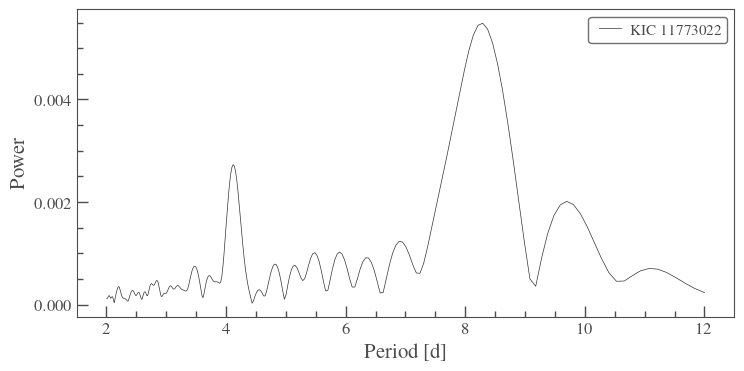

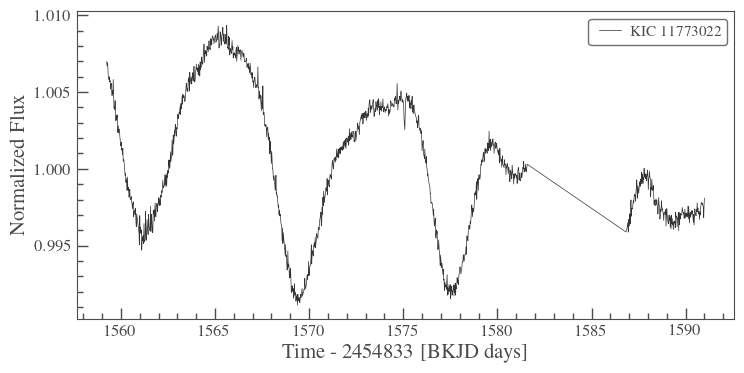

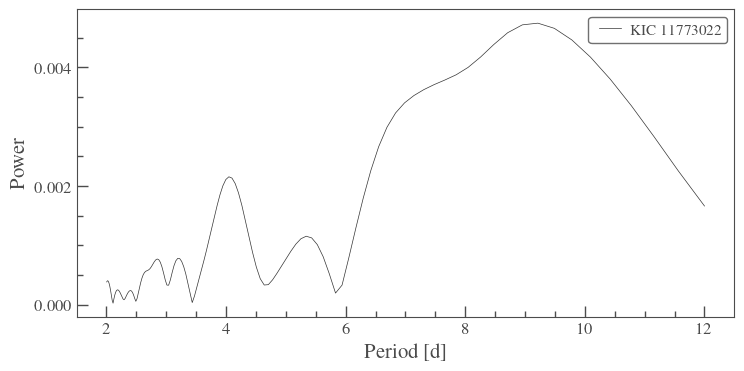

In [33]:
periods = []
dates = []
pows = []

for sr in search_result:
    if sr.exptime == 1800*u.s:
        lc = sr.download(download_dir='mastDownload/')
        lc = lc.normalize()
        lc.plot()

        pg = lc.to_periodogram(oversample_factor=10,minimum_period=2*u.d, maximum_period=12*u.day)

        tmid = (lc.time[0].value + lc.time[-1].value)/ 2
        dates.append(tmid)
        periods.append(pg.period_at_max_power.value)
        pows.append(pg.max_power)
        print(pg.period_at_max_power)
        # print(pg.max_power)

        pg.plot()

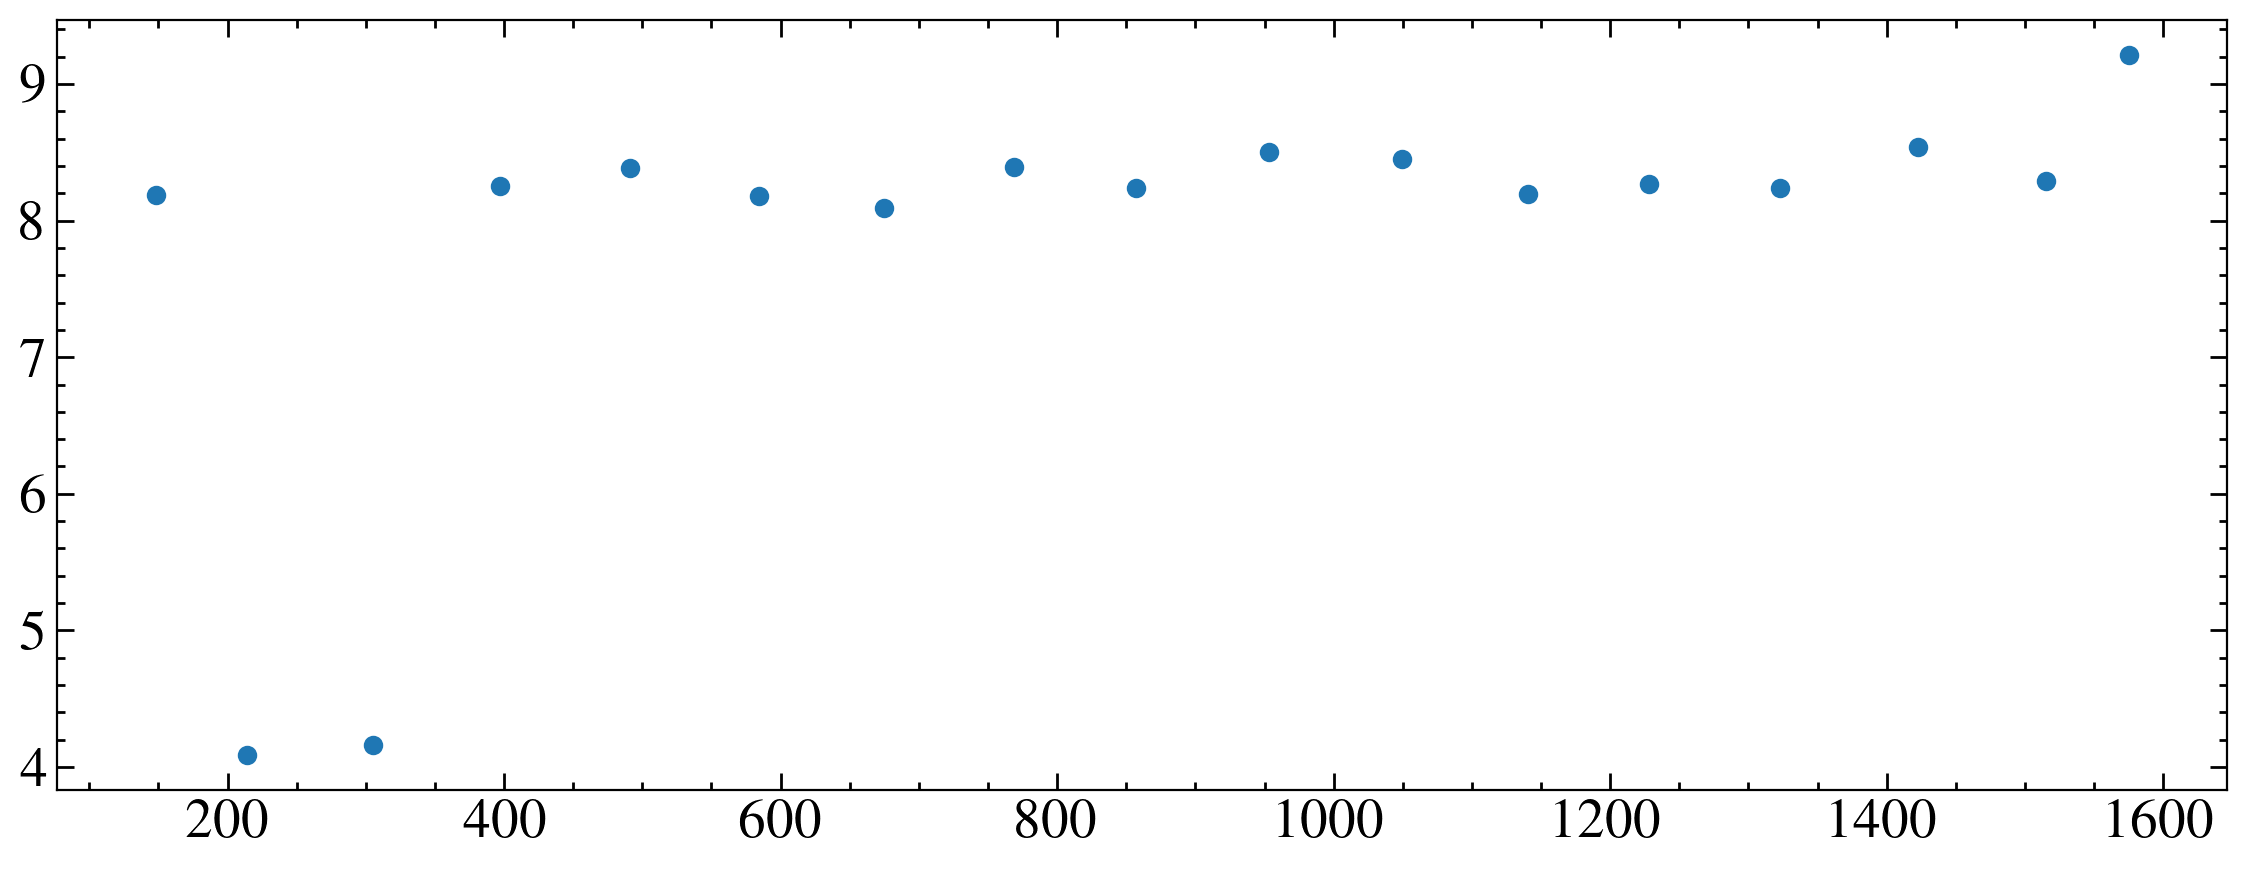

In [38]:
dates, periods, pows = np.array(dates), np.array(periods), np.array(pows) 

plt.scatter(dates, periods)

Text(0.5, 0, 'Time (?)')

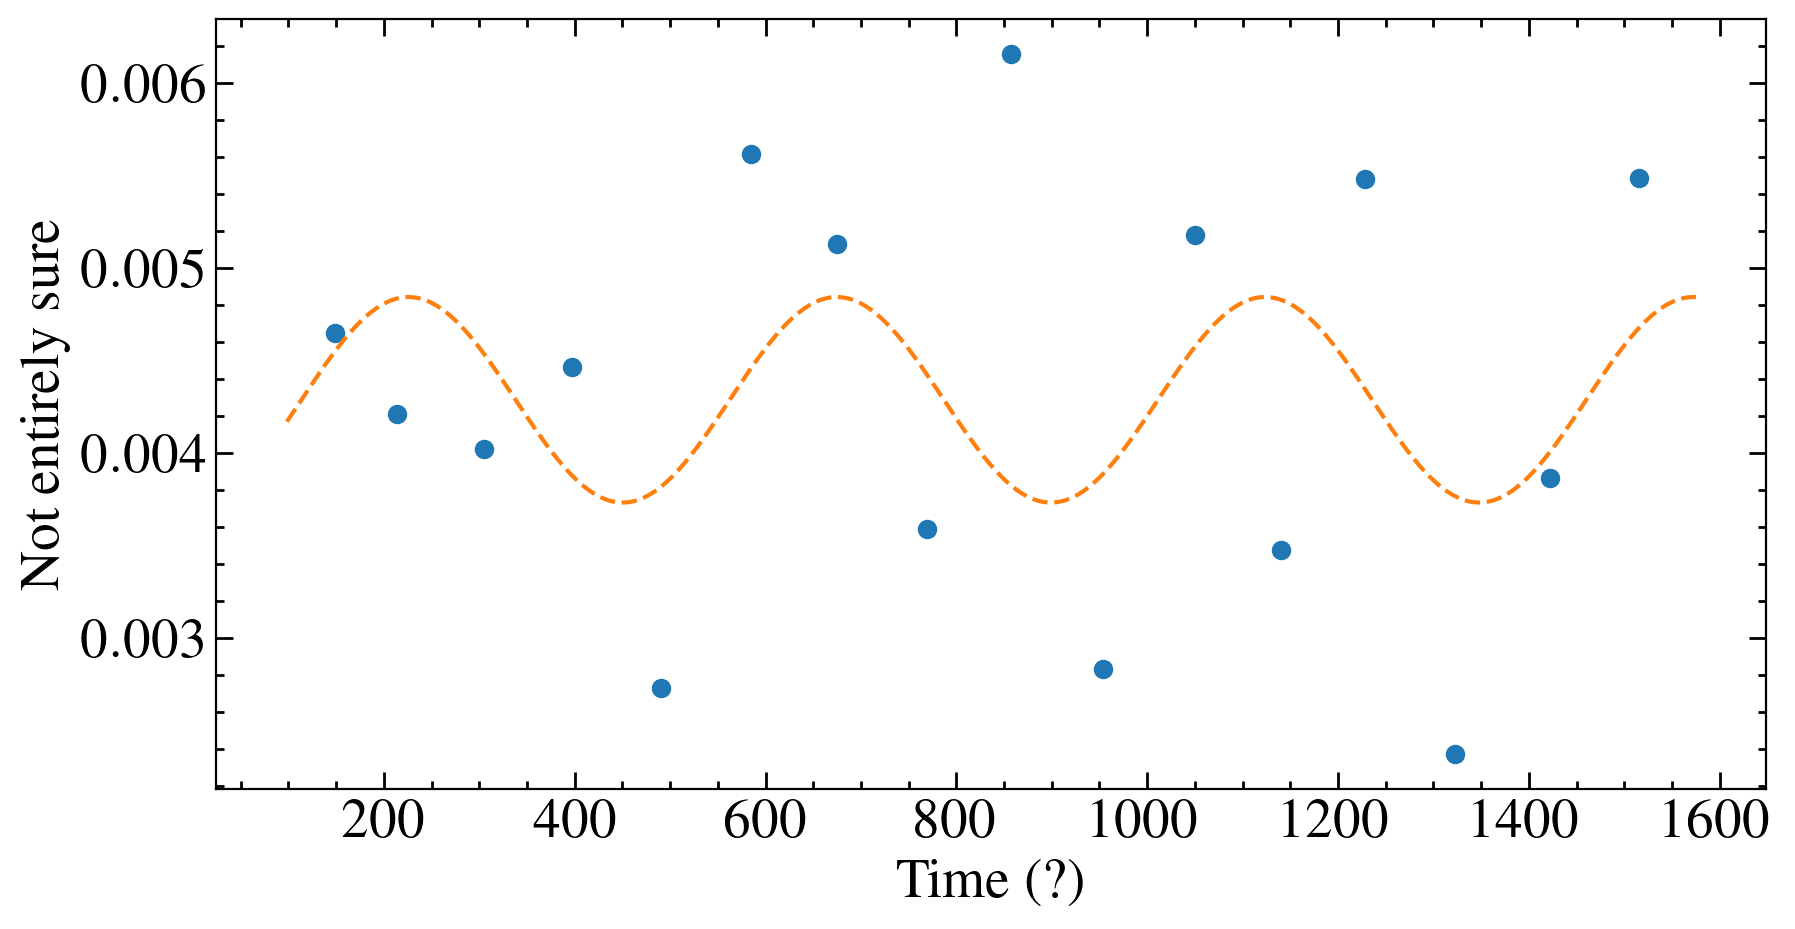

In [56]:
fig, ax = plt.subplots(figsize = (10, 5))

mask = (periods < 9) # incomplete lc at the end
# period_fix = np.copy(periods) # adjusting periods that are 0.5 * true period
# for i in range(len(periods)):
#     if periods[i] < 6:
#         period_fix[i] = periods[i]*2


ax.scatter(dates[mask], pows[mask])

#gonna fit a sinewave to this thing
fitter = fitting.LevMarLSQFitter()

sin_mod = models.Const1D(np.median(pows[mask])) + models.Sine1D(amplitude=0.05, frequency = 1/400, phase=0.1)

sin_fit = fitter(sin_mod, dates[mask], pows[mask])

tfit = np.linspace(min(dates)-50, max(dates), 1000)
ax.plot(tfit, sin_fit(tfit), c='C1', ls='--')
ax.set_ylabel('Not entirely sure')
ax.set_xlabel('Time (?)')


Well that didn't work. Have to calculate flare rate over time? Sounds hard. Eaiser - look at the IUE LWP spectra of Kap 1 Cet and see if it vairies enough to make the difference.